In [1]:
import sys
sys.path.append('../')
#import functions
#exec(open('./functions.py').read())
%run functions.py
import demoji
#demoji.download_codes()

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to C:\Users\Annelie
[nltk_data]     Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Annelie
[nltk_data]     Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Annelie
[nltk_data]     Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def classify_bots(df):
    #collect all the account names related to bots and scripts
    names = []
    pat = r'(bot\s|script|bot_)'
    for name in df.name.unique():
        match = re.findall(pat, name, re.IGNORECASE) 
        if len(match) > 0:
            names.append(name)
    #look for a key words to identify a tweet related to bots and scripts
    pattern = r"(script|bot\s|bots\s|bot_|cook|cop^e|destroy|proxy)"
    df['bot'] = False
    for i, row in df.iterrows():
        match = re.findall(pattern, row.tweet, re.IGNORECASE) 
        if len(match) > 0 or row.isin(names)['name'] == True:
            df['bot'].loc[i] = True
    return df

In [32]:
#load labelled data (generated in file 2.preprocessing_en)
data = pickle.load(open('data_n_models/eng_df_labelled.pkl', "rb"))

#filter out bot reated data
data = classify_bots(data)
data = data[data['bot']==False]
data = data[data['keyword']=='zalando']
data = data.drop_duplicates(subset=['lemma'])
data.head()


C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,index,user_id,user_statuses,name,tweet,retweets,location,created,followers,is_user_verified,favorite_count,in_reply_to_status_id,keyword,language,clean,clean_vader,compound,lemma,bot
0,0,819101311715131392,77,Ali09685762,@Zalando give me my money you owe me!!!,0,,07-Mar-2021,6,False,0.0,NaN,zalando,en,money owe,give money you owe me!!!,0.0000,money owe,False
1,1,1189512849472643072,105,Labellerr1,#VirtualStyling and try-on increases the conve...,0,chandigarh,06-Mar-2021,18,False,0.0,NaN,zalando,en,virtualstyling try increases conversion rate l...,VirtualStyling and try-on increases the conver...,0.7650,virtualstyle try increase conversion rate larg...,False
3,3,1125728513666048000,9604,DommeLineCoUk,@missbellalugosi @Zalando Problem starts at Ad...,0,,06-Mar-2021,2193,False,1.0,1.368196e+18,zalando,en,problem starts adidas selling latex websites,Problem starts Adidas. They're selling latex t...,-0.4019,problem start adida sell latex website,False
4,4,2614256724,35470,medboyUK,@missbellalugosi @Zalando Welcome to my world ...,0,"West Midlands, UK",06-Mar-2021,2503,False,1.0,1.368196e+18,zalando,en,welcome world sneering disdain,Welcome world sneering and disdain!,-0.1007,welcome world sneer disdain,False
5,5,978410484155199488,1549,missbellalugosi,Hey @Zalando these clothes are not made of la...,0,GERMANY / UK / USA,06-Mar-2021,13827,False,17.0,NaN,zalando,en,hey clothes latex plastic latex rubber stitche...,"Hey these clothes are not made latex, they are...",0.5362,hey clothe latex plastic latex rubber stitch r...,False


In [4]:
for i, value in data[10:20].lemma.iteritems():
    print(i, value)

12 send delivery paper bag
13 order eventually thing happen expectation feed information whomever concerned zalando
14 hey order product web shop item " fast delivery " suppose arrive today unfortunately ship parcel time happen sad
15 zalando think big pregnant suggest lovely maternity clothe ️ ️ ️ ️ ️ ️ ️ thank love ️ ️ ️ ️
16 think belong sport shoe section
17 new redezign circularity pilot product product pilot equip digital tag save product datum scan able discover product history digital product site ️ ️
18 zalando ride cargo bike delivery service netherland
19 order ship able provide status update
20 check new cto cto podcast format dedicate impactful tech in episode victoria schmierer share story implement pre own give new life clothe ecommerce sustainability reuse rewear
21 stay informed circular csnew energylabel come force march help consumer cut energy bill footprint zircle wardrobe future list ️ circulareconomy sdg


# clustering with LatentDirichletAllocation

https://ourcodingclub.github.io/tutorials/topic-modelling-python/

### Working with bot-filtered, zalando data. Looking at only 1000 tweets to get a first glimpse

The LDA model works based on probabilities. While every posts consists of a mix of topics (probability distribution of topics), every topic represents a mix of words (probability distribution of words). Based on the probabilities words that go together are assigned to a single topic.

In [33]:
# new try with only nouns
df = list(data['lemma'])

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Extracting the nouns from the text data 
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
# Tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import nltk
nltk.download('averaged_perceptron_tagger')
data = data.iloc[0:1000] # try only a subset for now


C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Annelie Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [84]:
data['tokens'] = data['lemma'].apply(lambda x: tokenizer.tokenize(x.lower())) # can't only use str as input need list of strings
noun= []
for row in data['tokens']:
    noun.append([word for word,pos in pos_tag(row) if pos == 'NN' or pos == 'JJ']) # tagging words as nouns/adjectives with nltk

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
# Create bigrams
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

bigram = gensim.models.Phrases(noun, min_count=5, threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
words = make_bigrams(noun)

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
# Step 1: create dicationary and corpus for topic modeling

# Create Dictionary
id2word = corpora.Dictionary(words)

# Create Corpus
texts = words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
id2word[0]

[[(0, 1), (1, 1)]]
C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'money'

The model below trains multiple LDA models with different topic numbers and their corresponding coherence score. According to the following blog post https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Topic%20Coherence%20measures%20score%20a,are%20artifacts%20of%20statistical%20inference the "Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference." The keywords describing the topic are coherent, if they support each other.

In [89]:
# Define the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
# Can take a long time to run (!!!)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words, start=1, limit=20, step=1)

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


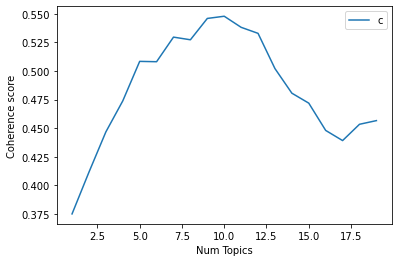

In [91]:
# Show graph
limit=20; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [92]:
## Step 2: build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=40,
                                           update_every=1, # how often the model parameters should be updated
                                           chunksize=100, # number of texts to be used in each training chunk
                                           passes=10, # total number of training passes
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this


C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Each circle on the left hand side represents a certain topic. The bigger the circle, the more relevant is the topic based on the input data. While putting the cursor on one of the circles, the right side of the chart illustrates the keywords the topic is formed by and their estimated term frequency within the selected topic. 

In [94]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.368023 -0.019065       1        1  29.413430
6      0.019987  0.320760       2        1  16.087549
4      0.028211 -0.014730       3        1  11.863917
3      0.048008 -0.067597       4        1   7.792658
5      0.031894 -0.044489       5        1   7.198646
7      0.061502 -0.044080       6        1   6.290021
1      0.054730 -0.040532       7        1   5.979573
9      0.022191 -0.042877       8        1   5.677049
0      0.047988 -0.012524       9        1   4.875803
2      0.053512 -0.034867      10        1   4.821354, topic_info=         Term        Freq       Total Category  logprob  loglift
95    zalando  601.000000  601.000000  Default  30.0000  30.0000
5        good   30.000000   30.000000  Default  29.0000  29.0000
436         s   29.000000   29.000000  Default  28.0000  28.0000
259   fashion   60.000000   60.000000  Default  27.0000  27.0000
311   account   61.000000   61.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
56       know    2.363583    3.000217  Topic10  -5.0330   2.7936
882         n    2.303578    2.940162  Topic10  -5.0587   2.7881
60       tell    2.300093    2.936676  Topic10  -5.0603   2.7878
1337   pocket    2.277185    2.913734  Topic10  -5.0703   2.7856
81       year    2.721582   16.116351  Topic10  -4.8920   1.2535

[355 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2403     10  0.901394    abaga
311       1  0.995615  account
1431      6  0.872923     adan
1790      3  0.975518      add
168       9  0.760307   advice
...     ...       ...      ...
81       10  0.186146     year
95        1  0.983177  zalando
95        2  0.016636  zalando
1509      3  0.155748    zlndy
1509      5  0.778740    zlndy

[337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 5, 4, 6, 8, 2, 10, 1, 3])

In [95]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.5014,"ecommerce, amazon, need, money, check, bad, ne...","[money, owe]"
1,1,4.0,0.8013,"fashion, stock, european, growth, europe, comp...","[virtualstyle, try, increase, conversion, rate..."
2,2,7.0,0.3419,"work, brand, woman, stay, website, black, body...","[problem, start, adida, website]"
3,3,2.0,0.4955,"buy, support, legit, dress, shirt, ship, mean,...","[welcome, world, sneer, disdain]"
4,4,0.0,0.7745,"good, sale, drop, plan, cop, hey, bit, idk, ra...","[hey, clothe, latex, plastic, latex, rubber, s..."
...,...,...,...,...,...
995,995,8.0,0.3477,"zalando, account, order, market, time, look, b...","[zalando, drop, start]"
996,996,8.0,0.6658,"zalando, account, order, market, time, look, b...","[zalando, thank]"
997,997,8.0,0.7300,"zalando, account, order, market, time, look, b...","[zalando, order, arrive]"
998,998,2.0,0.3997,"buy, support, legit, dress, shirt, ship, mean,...","[idk, ship, worldwide]"


In [96]:
# Build topic column for test set
Topics = df_dominant_topic['Dominant_Topic']
data['Topics'] = Topics

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
